In [26]:
import pandas as pd
import yfinance as yf
import numpy as np
from math import sqrt
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Func :

In [27]:
def PF_variance(weights, sigmas, correl):
    '''returns n-assets whole portfolio variance'''
    return float(np.dot(np.dot(np.dot(np.dot(weights.transpose(), sigmas), correl), sigmas), weights))

In [28]:
def PF_return(weights, returns):
    '''returns n-assets whole portfolio return'''
    return float(np.dot(weights.transpose(),returns))

In [29]:
def sim_PF(sig_lst, corr, ret, num_sim, risk_free=0.001): #
    '''compute PF weights combinations, of n-assets
    Montecarlo approach (since n is unknow)'''
    num_assets = len(sig_lst)
    result_list=[] #doing a list of dict and using it to build one last pandas df is faster than appending rows to existing DF
    #see https://stackoverflow.com/a/17496530
    
    #transform sigs into symetric matrix
    #   sig A   0 
    #   0       sig B
    sig = np.zeros((num_assets, num_assets), float)
    np.fill_diagonal(sig, sig_lst.values)
    
    for i in range(1,num_sim):
        w = pd.Series(np.random.random(num_assets), index=ret.index)
        w /= np.sum(w)
        i_ret=PF_return(w, ret)
        i_var=PF_variance(w, sig, corr)
        dict_tmp = {'weights':w, 'glob_ret':i_ret, 'stdev':np.sqrt(i_var), 'sharpe':((i_ret-risk_free)/np.sqrt(i_var))}
        result_list.append(dict_tmp)
    
    results = pd.DataFrame(result_list)
    return results  

In [30]:
def find_barrier(results):
    '''find the points located on the Markowitz efficient barrier'''
    results['glob_ret'] = results['glob_ret'].round(3)
    ret_range = results['glob_ret'].unique()

    barrier_coord = []
    for i in ret_range:
        stdev_tmp = results[results['glob_ret']==i]['stdev'].min()
        elt = {'ret':i, 'stdev':stdev_tmp}
        barrier_coord.append(elt)
        
    df = pd.DataFrame(barrier_coord)
    return df

In [31]:
def constr_optim_markowitz(returns):
    '''min PF_var under constraints : weights > 0 (no shorts), sum(weights)=1, returns > 0'''
    # Mean return for each stock (in array)
    r = np.array(np.mean(returns, axis=0))

    # Covariance matrix between stocks (in array)
    S = np.array(returns.cov())

    # Vector of 1's equal in length to r
    e = np.ones(len(r))

    # Set the projected mean return for the portfolio
    mu = 1+(0.07/252) # 7% rate annually per day
    
    def objective(w):
        return np.matmul(np.matmul(w,S),w)
    
    
    w = np.random.random(len(r))
    
    const = ({'type' : 'ineq' , 'fun' : lambda w: np.dot(w,r) - mu}, # returns - mu >= 0
         {'type' : 'eq' , 'fun' : lambda w: np.dot(w,e) - 1})    # sum(w) - 1 = 0
    
    # Create Bounds
    # Creates a tuple of tuples to pass to minimize
    # to ensure all weights are betwen [0, inf]
    non_neg = []
    for i in range(len(r)):
        non_neg.append((0,None))
    non_neg = tuple(non_neg)



    # Run optimization with SLSQP solver
    solution = minimize(fun=objective, x0=w, method='SLSQP',constraints=const,bounds=non_neg)
    w = solution.x.round(6)
    print(w)
    print(w.sum())
    print(list(returns.columns[w > 0.0]))


In [32]:
def plot_pf_sim(results, barrier, nsim):
    ax,fig = plt.subplots(figsize=(15,10))
    plt.title("PF sim ({}-sim)".format(nsim))
    plt.scatter(x=results['stdev'], y=results['glob_ret'], c=results['sharpe'])
    plt.scatter(x=barrier['stdev'], y=barrier['ret'], color='red')
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Sharpe')

    plt.xlabel("stdev")
    plt.ylabel("expected return")
    plt.show()

# Analysis :

In [33]:
portfolio = pd.DataFrame(columns=["ticker", "date_in", "spot_in", "cost_eur", "nb", "currency", "current_val", "date_out", "price_out", "cost_out"])
portfolio = portfolio.append({\
                  "ticker":"UBER",\
                  "date_in":dt.datetime(2019,11,26),\
                  "spot_in":29.0998,\
                  "cost_eur":800.43,\
                  "nb":29.0,\
                  "currency":"usd"}, ignore_index=True)

portfolio = portfolio.append({\
                  "ticker":"MITRA.BR",\
                  "date_in":dt.datetime(2020,2,13),\
                  "spot_in":26.88,\
                  "cost_eur":537.6,\
                  "nb":20.0,\
                  "currency":"eur"}, ignore_index=True)
display(portfolio)

,ticker,date_in,spot_in,cost_eur,nb,currency,current_val,date_out,price_out,cost_out
0,UBER,2019-11-26,29.0998,800.43,29.0,usd,NaN,NaN,NaN,NaN
1,MITRA.BR,2020-02-13,26.8800,537.60,20.0,eur,NaN,NaN,NaN,NaN


In [34]:
#TO MODIFY : pick a TBond + prompt version
risk_free_rate = 0.0178

In [35]:
#TO MODIFY (prompt version) in standalone version
end = dt.date.today()
start = dt.datetime(2016, 5, 10)

In [36]:
yf.download("EURUSD=X", start=dt.date.today())["Low"][-1]


[*********************100%***********************]  1 of 1 completed


1.0794472694396973

In [37]:
prices = yf.download(portfolio['ticker'].tolist(), start=start, end=end)
currencies = pd.DataFrame(columns=['rate'])
currencies.loc['usd'] = float(yf.download("EURUSD=X", start=dt.date.today())["Low"][-1]) #Low for the lowest estimation
currencies.loc['eur'] = 1
currencies.loc['foo'] = 0.0000001

currencies

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed


,rate
usd,1.079447e+00
eur,1.000000e+00
foo,1.000000e-07


In [38]:
display(prices)

Adj Close             Close              High             \
             MITRA.BR   UBER   MITRA.BR   UBER   MITRA.BR       UBER   
Date                                                                   
2016-05-10   9.001000    NaN   9.001000    NaN   9.500000        NaN   
2016-05-11   9.160000    NaN   9.160000    NaN   9.390000        NaN   
2016-05-12   9.390000    NaN   9.390000    NaN   9.390000        NaN   
2016-05-13   9.460000    NaN   9.460000    NaN   9.467000        NaN   
2016-05-16   9.400000    NaN   9.400000    NaN   9.460000        NaN   
...               ...    ...        ...    ...        ...        ...   
2020-02-12  27.120001  41.25  27.120001  41.25  27.139999  41.860001   
2020-02-13  26.920000  40.09  26.920000  40.09  27.320000  41.549999   
2020-02-14  26.680000  39.66  26.680000  39.66  27.080000  40.310001   
2020-02-17  26.700001    NaN  26.700001    NaN  26.959999        NaN   
2020-02-18        NaN  40.18        NaN  40.18        NaN  40.270000   

                  Low                Open              Volume              
             MITRA.BR       UBER MITRA.BR       UBER MITRA.BR        UBER  
Date                                                                       
2016-05-10   9.000000        NaN     9.50        NaN   4835.0         NaN  
2016-05-11   9.000000        NaN     9.39        NaN   3130.0         NaN  
2016-05-12   9.210000        NaN     9.38        NaN   2284.0         NaN  
2016-05-13   9.390000        NaN     9.39        NaN    875.0         NaN  
2016-05-16   9.400000        NaN     9.46        NaN    160.0         NaN  
...               ...        ...      ...        ...      ...         ...  
2020-02-12  26.820000  41.064999    27.00  41.500000  47819.0  26444900.0  
2020-02-13  26.660000  40.000000    27.00  40.930000  31510.0  23850900.0  
2020-02-14  26.459999  38.700001    27.08  40.020000  27369.0  32014200.0  
2020-02-17  26.420000        NaN    26.42        NaN  26293.0         NaN  
2020-02-18        NaN  39.450001      NaN  39.490002      NaN  22149300.0  

[968 rows x 12 columns]

## Report : mean ret, Markowitz

C:\Users\sv5011\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


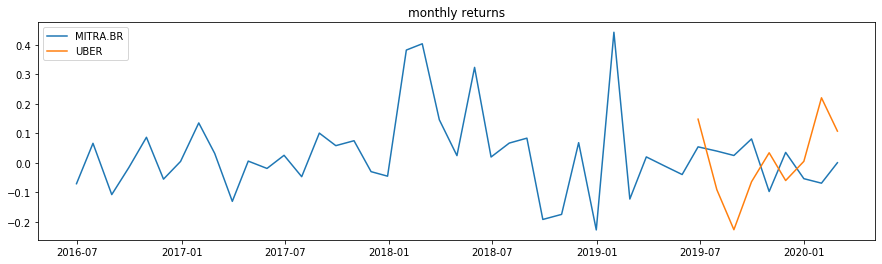

MITRA.BR


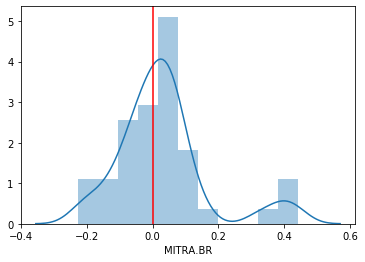

mean monthly returns : 
0.02854510285770305 
monthly returns stdev : 
0.14069648681115587
kurtosis (monthly): 2.3183903458807316
skewnes (monthly): 1.2337026664711115
global return (daily) : 0.11792526210191523
global stdev (daily) : 0.02525378809830204


UBER


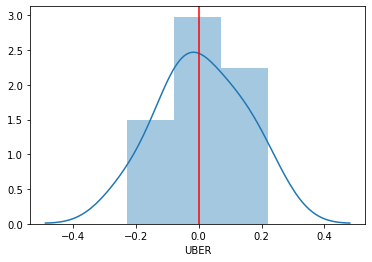

mean monthly returns : 
0.007821170679643805 
monthly returns stdev : 
0.13700565146394428
kurtosis (monthly): -0.23136139547419887
skewnes (monthly): -0.08210051389435054
global return (daily) : 0.03348826718718412
global stdev (daily) : 0.02898361249277068


PF correl coef : 0.1730918641462703


In [39]:
returns_monthly = prices["Adj Close"].resample('BM').apply(lambda x: x[-1]).pct_change()
means_returns = returns_monthly.mean()
sigmas_monthly = returns_monthly.std()

fig, ax = plt.subplots(figsize=(15,4))
plt.plot(returns_monthly)
plt.legend(returns_monthly.columns.values,loc='upper left')
plt.title("monthly returns")
plt.show()


returns = prices["Adj Close"].dropna().pct_change().cumsum(axis=0).iloc[-1] #dropna in order to compare same timeframe
sigmas = prices["Adj Close"].dropna().pct_change().std()
correl = np.corrcoef(np.array(prices["Adj Close"].dropna().pct_change().dropna().T))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    for i in returns_monthly.columns:
        print(i)
        sns.distplot(returns_monthly[i].dropna())
        plt.axvline(0, color="red")
        plt.show()
        print("mean monthly returns : \n{} \nmonthly returns stdev : \n{}".format(means_returns[i], sigmas_monthly[i]))
        print("kurtosis (monthly): {}".format(returns_monthly[i].kurtosis()))
        print("skewnes (monthly): {}".format(returns_monthly[i].skew()))

        print("global return (daily) : {}".format(returns[i]))
        print("global stdev (daily) : {}\n\n".format(sigmas[i]))
    print("PF correl coef : {}".format(correl[0,1]))

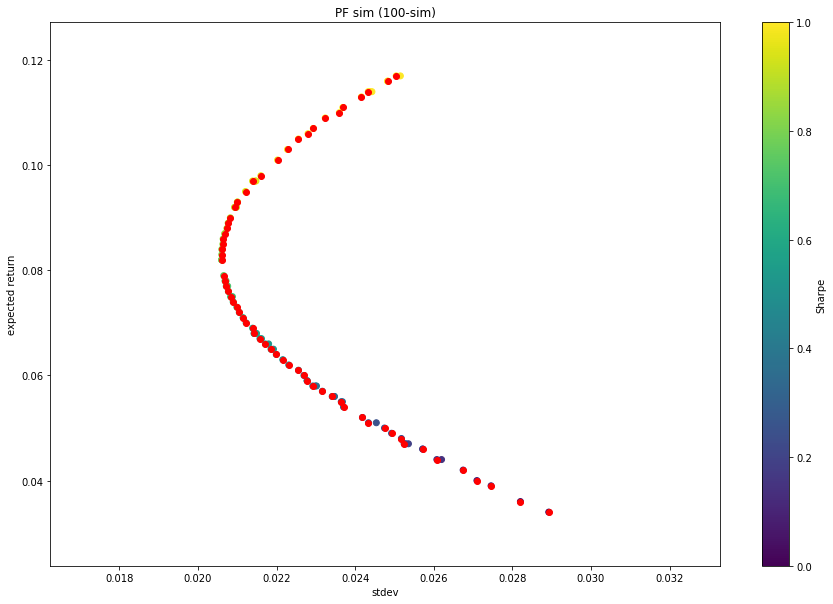

max Sharpe : 4.6413421565245585 (100-sim) 
 weights : MITRA.BR    0.943145
UBER        0.056855
dtype: float64
max return : 0.117 (stdev : 0.025149433728964825)
min stdev : 0.028927133075024154 (return : 0.034)


In [40]:
nsim=100
simulated_PF = sim_PF(sigmas, correl, returns, num_sim=nsim)

barrier = find_barrier(simulated_PF)
plot_pf_sim(simulated_PF, barrier, nsim)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("max Sharpe : {} ({}-sim) \n weights : {}".format(simulated_PF.iloc[simulated_PF['sharpe'].idxmax()]['sharpe'], nsim, simulated_PF.iloc[simulated_PF['sharpe'].idxmax()]['weights']))
    print("max return : {} (stdev : {})".format(simulated_PF.iloc[simulated_PF['glob_ret'].idxmax()]['glob_ret'], simulated_PF.iloc[simulated_PF['glob_ret'].idxmax()]['stdev']))
    print("min stdev : {} (return : {})".format(simulated_PF.iloc[simulated_PF['stdev'].idxmax()]['stdev'], simulated_PF.iloc[simulated_PF['stdev'].idxmax()]['glob_ret']))

In [41]:
simulated_PF

,weights,glob_ret,stdev,sharpe
0,MITRA.BR 0.220611 UBER 0.779389 dtyp...,0.052,0.024185,2.113578
1,MITRA.BR 0.212338 UBER 0.787662 dtyp...,0.051,0.024337,2.071600
2,MITRA.BR 0.032103 UBER 0.967897 dtyp...,0.036,0.028205,1.247978
3,MITRA.BR 0.408031 UBER 0.591969 dtyp...,0.068,0.021489,3.115197
4,MITRA.BR 0.446445 UBER 0.553555 dtyp...,0.071,0.021146,3.319089
...,...,...,...,...
94,MITRA.BR 0.861658 UBER 0.138342 dtyp...,0.106,0.022799,4.616212
95,MITRA.BR 0.14261 UBER 0.85739 dtype:...,0.046,0.025719,1.731372
96,MITRA.BR 0.125692 UBER 0.874308 dtyp...,0.044,0.026078,1.652780
97,MITRA.BR 0.063853 UBER 0.936147 dtyp...,0.039,0.027458,1.379554


## Report : follow-up :

In [42]:
#portfolio['current_val'] = portfolio['nb'] * portfolio['rate']
#portfolio.set_index('ticker')['current_val'] = portfolio.set_index('ticker')['current_val'] * prices["Adj Close"].dropna().iloc[-1]


portfolio['current_val'] = portfolio['ticker'].map(prices["Adj Close"].dropna().iloc[-1]) * \
                            portfolio['nb'] / portfolio['currency'].map(currencies['rate'])
portfolio

,ticker,date_in,spot_in,cost_eur,nb,currency,current_val,date_out,price_out,cost_out
0,UBER,2019-11-26,29.0998,800.43,29.0,usd,1065.489745,NaN,NaN,NaN
1,MITRA.BR,2020-02-13,26.8800,537.60,20.0,eur,533.600006,NaN,NaN,NaN


In [43]:
total_value = np.sum(portfolio['current_val'])

actual_weights = portfolio.set_index('ticker')['current_val'] / total_value

actual_return = PF_return(actual_weights, returns)
actual_stdev = np.sqrt(PF_variance(actual_weights, sigmas, correl))


print("PF current adjusted total value (€) : {} (eurusd = {})".format(total_value, currencies.loc['usd', 'rate']))
print("actual weights :\n{}".format(actual_weights))
print("max Sharpe weights :\n{}".format(simulated_PF['weights'].loc[simulated_PF['sharpe'].idxmax()]))
print("----")
print("actual expected return : {}".format(actual_return))
print("returns computed for max Sharpe : {}".format(simulated_PF['glob_ret'].loc[simulated_PF['sharpe'].idxmax()]))
print("----")
print("actual expected stdev : {}".format(actual_stdev))
print("stdev computed for max Sharpe : {}".format(simulated_PF['stdev'].loc[simulated_PF['sharpe'].idxmax()]))
print("----")
print("actual Sharpe : {}".format(actual_return/actual_stdev))
print("max theoretical Sharpe : {}".format(simulated_PF['sharpe'].loc[simulated_PF['sharpe'].idxmax()]))

PF current adjusted total value (€) : 1599.089750842921 (eurusd = 1.0794472694396973)
actual weights :
ticker
UBER        0.66631
MITRA.BR    0.33369
Name: current_val, dtype: float64
max Sharpe weights :
MITRA.BR    0.943145
UBER        0.056855
dtype: float64
----
actual expected return : 0.08974949462037575
returns computed for max Sharpe : 0.113
----
actual expected stdev : 0.02879920316886779
stdev computed for max Sharpe : 0.0241578035625528
----
actual Sharpe : 3.1163881199808956
max theoretical Sharpe : 4.6413421565245585
